In [ ]:
!jupyter nbconvert feature_engineering.ipynb --to script --output features_engineering --TagRemovePreprocessor.remove_cell_tags='{"remove"}'

In [ ]:
!jupyter nbconvert tgt_baseline.ipynb --to script --output target_metrics_baseline --TagRemovePreprocessor.remove_cell_tags='{"remove"}'

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
train = pd.read_csv('train_FD001.csv')
test = pd.read_csv('test_FD001.csv')
rul = pd.read_csv('RUL_FD001.csv')

In [3]:
print('train:', train.shape)
print('test:', test.shape)
test.head(2)

train: (20631, 26)
test: (13096, 26)


,Unit,Time,OperationalSetting1,OperationalSetting2,OperationalSetting3,Sensor-1Measurement,Sensor-2Measurement,Sensor-3Measurement,Sensor-4Measurement,Sensor-5Measurement,...,Sensor-12Measurement,Sensor-13Measurement,Sensor-14Measurement,Sensor-15Measurement,Sensor-16Measurement,Sensor-17Measurement,Sensor-18Measurement,Sensor-19Measurement,Sensor-20Measurement,Sensor-21Measurement
0,1,1,0.0023,0.0003,100,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100,38.86,23.3735
1,1,2,-0.0027,-0.0003,100,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100,39.02,23.3916


In [4]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_validate

In [5]:
class CustomGroupKFold(GroupKFold):
    def split(self, X, y, groups):
        splits = super().split(X, y, groups)

        for train_ind, val_ind in splits:
            yield train_ind, val_ind[(y[val_ind] > 6) & (y[val_ind] < 135)]

In [9]:
def evaluate(model, X, y, groups, cv, 
             scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'], 
             n_jobs=None, 
             verbose=False):
    cv_results = cross_validate(
        model, 
        X=X,
        y=y,
        groups=groups,
        scoring=scoring,
        cv=cv,
        return_train_score=True,
        return_estimator=True,
        n_jobs=n_jobs,
        verbose=verbose
    )
    
    for k, v in cv_results.items():
        if k.startswith('train_') or k.startswith('test_'):
            k_sp = k.split('_')
            print(f'[{k_sp[0]}] :: {" ".join(k_sp[2:])} : {np.abs(v.mean()):.2f} +- {v.std():.2f}')
    return cv_results

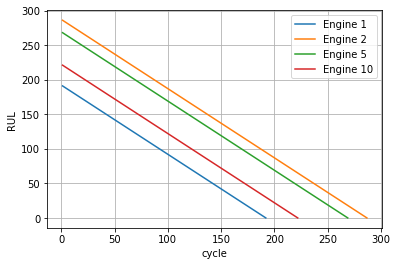

c:\Users\Sunil kumar\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Sunil kumar\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


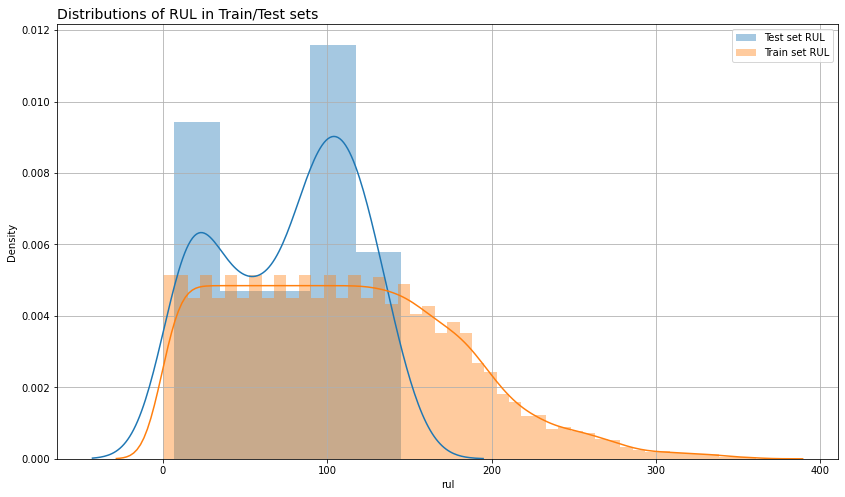

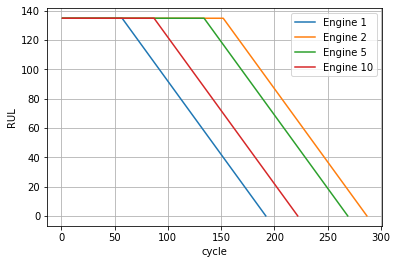

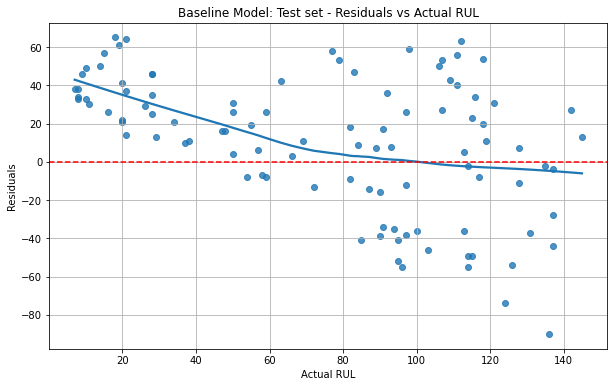

In [10]:
from target_metrics_baseline import plot_residuals_vs_actual
from target_metrics_baseline import rul_metrics_score

In [11]:
def test_model(model, X_test, engines, test_rul, plot_figures=False, **plot_kwargs):
    X_test_last = X_test.groupby(engines, as_index=False).last()

    if plot_figures:
        pred_rul = model.predict(X_test_last.values)
        plot_residuals_vs_actual(rul.to_numpy().flatten(), pred_rul, **plot_kwargs)

    return rul_metrics_score(model, X_test_last.values, test_rul, metrics='all')

Linear Model

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor
from sklearn.compose import make_column_selector

from target_metrics_baseline import calculate_RUL

In [13]:
RUL_THRESHOLD = 135

In [14]:
get_ftr_names = make_column_selector(pattern='Sensor')

model = Pipeline([
    ('scale', StandardScaler()),
    ('model', PoissonRegressor(alpha=0.1))
])

cv_result = evaluate(
    model,
    X=train[get_ftr_names(train)].values, 
    y=calculate_RUL(train, upper_threshold=RUL_THRESHOLD), 
    groups=train['Unit'], 
    cv=CustomGroupKFold(n_splits=5)
)

[test] :: root mean squared error : 23.16 +- 2.25
[train] :: root mean squared error : 25.98 +- 0.48
[test] :: mean absolute error : 18.52 +- 2.22
[train] :: mean absolute error : 21.06 +- 0.51


In [15]:
pip install sktime

Note: you may need to restart the kernel to use updated packages.


In [16]:
from features_engineering import LowVarianceFeaturesRemover, ScalePerEngine

train.shape = (20631, 27)
Droped low variance features: ['OperationalSetting3', 'Sensor-1Measurement', 'Sensor-5Measurement', 'Sensor-10Measurement', 'Sensor-16Measurement', 'Sensor-18Measurement', 'Sensor-19Measurement']
Start Rolling TS


Rolling: 100%|██████████| 20/20 [00:20<00:00,  1.05s/it]


Done Rolling TS in 0:00:22.333203
Start Extracting Features


Feature Extraction: 100%|██████████| 20/20 [12:22<00:00, 37.13s/it]


Done Extracting Features in 0:13:09.453888
Droped 19 duplicate features
Droped 13 features with NA values
Selected 9 out of 40 features: [0, 2, 3, 4, 5, 1, 10, 15, 31]
Droped low variance features: ['OperationalSetting3', 'Sensor-1Measurement', 'Sensor-5Measurement', 'Sensor-10Measurement', 'Sensor-16Measurement', 'Sensor-18Measurement', 'Sensor-19Measurement']
Start Rolling TS


Rolling: 100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


Done Rolling TS in 0:00:14.062069
Start Converting multi-index DF to sktime nested DF
Converted multi-index DF to sktime nested DF in 0:11:04.432143


In [17]:
sensor_names = ['Sensor-{}Measurement'.format(i) for i in range(1,22)] 

In [18]:
from sklearn.pipeline import Pipeline

In [19]:
preprocess_pipe = Pipeline([
     # Scaling sensors values
    ('scale-per-engine', ScalePerEngine(n_first_cycles=15, sensors_columns=sensor_names)),
    # Cleaning constant features
    ('drop-low-variance', LowVarianceFeaturesRemover(threshold=0))
])

train_sc = preprocess_pipe.fit_transform(train)

Droped low variance features: ['OperationalSetting3', 'Sensor-1Measurement', 'Sensor-5Measurement', 'Sensor-10Measurement', 'Sensor-16Measurement', 'Sensor-18Measurement', 'Sensor-19Measurement']


In [20]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('model', PoissonRegressor(alpha=0.1))
])

cv_result = evaluate(
    model, 
    X=train_sc[get_ftr_names(train_sc)].values, 
    y=calculate_RUL(train_sc, upper_threshold=RUL_THRESHOLD), 
    groups=train_sc['Unit'], 
    cv=CustomGroupKFold(n_splits=5)
)

[test] :: root mean squared error : 19.18 +- 0.79
[train] :: root mean squared error : 19.63 +- 0.11
[test] :: mean absolute error : 15.00 +- 0.61
[train] :: mean absolute error : 15.40 +- 0.11


Poisson Regression with TSfresh Features

In [21]:
from features_engineering import (RollTimeSeries, TSFreshFeaturesExtractor, CustomPCA, TSFreshFeaturesSelector, tsfresh_calc)

In [22]:
features_long_h_pipe = Pipeline([    
    # Scaling 
    ('scale-per-engine', ScalePerEngine(n_first_cycles=10, sensors_columns=sensor_names)),
    # Cleaning
    ('drop-low-variance', LowVarianceFeaturesRemover(threshold=0)),
    #Preprocessing
    ('roll-time-series', RollTimeSeries(min_timeshift=19, max_timeshift=19, rolling_direction=1)),
    
    # TSFresh features engineering
    ('extract-tsfresh-features', TSFreshFeaturesExtractor(calc=tsfresh_calc)),
    ('PCA', CustomPCA(n_components=20)),
    ('features-selection', TSFreshFeaturesSelector(fdr_level=0.001)),
])

In [23]:
features_short_h_pipe = Pipeline([    
    # Scaling 
    ('scale-per-engine', ScalePerEngine(n_first_cycles=10, sensors_columns=sensor_names)),
    # Cleaning
    ('drop-low-variance', LowVarianceFeaturesRemover(threshold=0)),
    #Preprocessing
    ('roll-time-series', RollTimeSeries(min_timeshift=4, max_timeshift=4, rolling_direction=1)),
    
    # TSFresh features engineering
    ('extract-tsfresh-features', TSFreshFeaturesExtractor(calc={'mean': None})),
    ('features-selection', TSFreshFeaturesSelector(fdr_level=0.0002)),
])

In [24]:
train_long_h_ftrs = features_long_h_pipe.fit_transform(train)

Droped low variance features: ['OperationalSetting3', 'Sensor-1Measurement', 'Sensor-5Measurement', 'Sensor-10Measurement', 'Sensor-16Measurement', 'Sensor-18Measurement', 'Sensor-19Measurement']
Start Rolling TS


Rolling: 100%|██████████| 20/20 [01:10<00:00,  3.51s/it]


Done Rolling TS in 0:01:12.142896
Start Extracting Features


Feature Extraction: 100%|██████████| 20/20 [11:50<00:00, 35.50s/it]


Done Extracting Features in 0:12:53.118594
Droped 19 duplicate features
Droped 13 features with NA values
Selected 10 out of 20 features: [0, 2, 3, 4, 1, 5, 6, 8, 15, 7]


In [27]:
import pickle
pickle.dump(train_long_h_ftrs, open('train_long_h_ftrs.pkl','wb'))

In [25]:
train_short_h_ftrs = features_short_h_pipe.fit_transform(train)

Droped low variance features: ['OperationalSetting3', 'Sensor-1Measurement', 'Sensor-5Measurement', 'Sensor-10Measurement', 'Sensor-16Measurement', 'Sensor-18Measurement', 'Sensor-19Measurement']
Start Rolling TS


Rolling: 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


Done Rolling TS in 0:00:14.007954
Start Extracting Features


Feature Extraction: 100%|██████████| 20/20 [00:40<00:00,  2.01s/it]


Done Extracting Features in 0:00:41.571154
Droped 0 duplicate features
Droped 0 features with NA values
Selected 15 out of 15 features: ['Sensor-2Measurement__mean', 'Sensor-3Measurement__mean', 'Sensor-4Measurement__mean', 'Sensor-7Measurement__mean', 'Sensor-8Measurement__mean', 'Sensor-9Measurement__mean', 'Sensor-11Measurement__mean', 'Sensor-12Measurement__mean', 'Sensor-13Measurement__mean', 'Sensor-15Measurement__mean', 'Sensor-17Measurement__mean', 'Sensor-20Measurement__mean', 'Sensor-21Measurement__mean', 'Sensor-14Measurement__mean', 'Sensor-6Measurement__mean']


In [29]:
pickle.dump(train_short_h_ftrs, open('train_short_h_ftrs.pkl','wb'))

In [26]:
train_ftrs = train_long_h_ftrs.merge(train_short_h_ftrs, how='inner', right_index=True, left_index=True)
train_ftrs.index = train_ftrs.index.set_names(['Unit', 'Time'])

print('train_ftrs: ', train_ftrs.shape)
train_ftrs.head(2)

train_ftrs:  (17731, 25)


0         2         3         4         1         5  \
Unit Time                                                               
1.0  30.0 -9.617814 -1.435505  5.182424  0.054635 -1.197233  0.807334   
     31.0 -9.602717 -1.297968  5.129612  0.178769 -1.074985  1.974322   

                  6         8        15         7  ...  \
Unit Time                                          ...   
1.0  30.0 -0.660171  1.903688 -0.233581  4.071652  ...   
     31.0 -0.920522  1.937442 -0.524550  3.034159  ...   

           Sensor-9Measurement__mean  Sensor-11Measurement__mean  \
Unit Time                                                          
1.0  30.0                     -1.360                       0.064   
     31.0                      0.974                       0.094   

           Sensor-12Measurement__mean  Sensor-13Measurement__mean  \
Unit Time                                                           
1.0  30.0                       0.144                       0.022   
     31.0                       0.078                       0.022   

           Sensor-15Measurement__mean  Sensor-17Measurement__mean  \
Unit Time                                                           
1.0  30.0                     0.00927                         0.2   
     31.0                     0.00615                        -0.2   

           Sensor-20Measurement__mean  Sensor-21Measurement__mean  \
Unit Time                                                           
1.0  30.0               -1.600000e-02                    -0.00622   
     31.0               -2.842171e-15                    -0.02214   

           Sensor-14Measurement__mean  Sensor-6Measurement__mean  
Unit Time                                                         
1.0  30.0                       0.566                        0.0  
     31.0                      -0.608                        0.0  

[2 rows x 25 columns]

In [27]:
X_train = train_ftrs.reset_index().drop(columns=['Unit'])

train_units_df = train_ftrs.index.to_frame(index=False)
y_train = calculate_RUL(train_units_df, upper_threshold=RUL_THRESHOLD)

In [28]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('model', PoissonRegressor(alpha=0.01))
])

cv_res = evaluate(
    model, 
    X=X_train.values, 
    y=y_train, 
    groups=train_units_df['Unit'], 
    cv=CustomGroupKFold(n_splits=5)
)

[test] :: root mean squared error : 13.81 +- 1.22
[train] :: root mean squared error : 14.08 +- 0.20
[test] :: mean absolute error : 10.85 +- 0.89
[train] :: mean absolute error : 11.05 +- 0.17


NGBoost

In [29]:
pip install --upgrade ngboost

In [30]:

from ngboost import NGBRegressor
from ngboost.distns import LogNormal, Poisson

In [31]:
ngb = NGBRegressor(Dist=Poisson)

cv_res = evaluate(
    ngb,
    X=X_train.values, 
    y=y_train, 
    groups=train_units_df['Unit'], 
    cv=CustomGroupKFold(n_splits=4),
    n_jobs=4
)

[test] :: root mean squared error : 13.47 +- 0.49
[train] :: root mean squared error : 12.27 +- 0.12
[test] :: mean absolute error : 10.16 +- 0.44
[train] :: mean absolute error : 9.41 +- 0.09


In [32]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [33]:
param_grid = {
    'Base': [
        DecisionTreeRegressor(criterion='friedman_mse', max_depth=4),
        DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, max_features=0.8, min_samples_split=50),
    ],
    'minibatch_frac': [1, 0.8, 0.5],
}


ngb = NGBRegressor(Dist=Poisson, learning_rate=0.02, n_estimators=500, verbose=False)

grid_search = GridSearchCV(
    ngb,
    scoring='neg_root_mean_squared_error',
    param_grid=param_grid, 
    cv=CustomGroupKFold(n_splits=4),
    n_jobs=6
)

grid_search.fit(X_train[y_train > 0].values, 
                y_train[y_train > 0], 
                groups=train_units_df[y_train > 0]['Unit'])

GridSearchCV(cv=CustomGroupKFold(n_splits=4),
             estimator=NGBRegressor(Dist=<class 'ngboost.distns.poisson.Poisson'>,
                                    learning_rate=0.02,
                                    random_state=RandomState(MT19937) at 0x1D85172DE40,
                                    verbose=False),
             n_jobs=6,
             param_grid={'Base': [DecisionTreeRegressor(criterion='friedman_mse',
                                                        max_depth=4),
                                  DecisionTreeRegressor(criterion='friedman_mse',
                                                        max_depth=5,
                                                        max_features=0.8,
                                                        min_samples_split=50)],
                         'minibatch_frac': [1, 0.8, 0.5]},
             scoring='neg_root_mean_squared_error')

In [34]:
ngb_base = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, max_features=0.8, min_samples_leaf=50)
ngb = NGBRegressor(Dist=Poisson, Base=ngb_base, learning_rate=0.01, 
                   col_sample=0.8, minibatch_frac=0.5, n_estimators=400)

cv_res = evaluate(
    ngb,
    X=X_train[y_train > 0].values, 
    y=y_train[y_train > 0], 
    groups=train_units_df[y_train > 0]['Unit'], 
    cv=CustomGroupKFold(n_splits=4),
    n_jobs=4
)

[test] :: root mean squared error : 12.76 +- 0.26
[train] :: root mean squared error : 9.98 +- 0.07
[test] :: mean absolute error : 9.51 +- 0.33
[train] :: mean absolute error : 7.29 +- 0.06


In [35]:
ftr_importance = pd.DataFrame()
for i, cv_estimator in enumerate(cv_res['estimator']):
    ftr_importance = ftr_importance.append(
        pd.DataFrame({
        'cv_iter': i,
        'feature': X_train.columns,
        'importance': cv_estimator.feature_importances_.reshape(-1).round(5)
        }),
        ignore_index=True
    )

ftr_importance_agg = (ftr_importance
    .groupby('feature')['importance']
    .agg(['mean', 'std'])
    .sort_values('mean', ascending=False)
    .reset_index()
)

ftr_importance_agg

C:\Users\Sunil kumar\AppData\Local\Temp\ipykernel_27236\3677255870.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ftr_importance = ftr_importance.append(


,feature,mean,std
0,0,0.304978,0.015142
1,Sensor-4Measurement__mean,0.108000,0.025468
2,Sensor-11Measurement__mean,0.081397,0.028543
3,Time,0.066367,0.004837
4,Sensor-15Measurement__mean,0.063268,0.005296
5,Sensor-6Measurement__mean,0.048660,0.006319
6,Sensor-21Measurement__mean,0.042335,0.024612
7,Sensor-9Measurement__mean,0.029263,0.006708
8,3,0.025100,0.007360
9,2,0.023505,0.002960


In [36]:
drop_features = ftr_importance_agg['feature'].iloc[-6:].values
drop_features

array(['Sensor-8Measurement__mean', 8, 'Sensor-2Measurement__mean', 15,
       'Sensor-13Measurement__mean', 'Sensor-17Measurement__mean'],
      dtype=object)

In [37]:
SELECTED_FEATURES = ftr_importance_agg['feature'].iloc[:-6].values
SELECTED_FEATURES

array([0, 'Sensor-4Measurement__mean', 'Sensor-11Measurement__mean',
       'Time', 'Sensor-15Measurement__mean', 'Sensor-6Measurement__mean',
       'Sensor-21Measurement__mean', 'Sensor-9Measurement__mean', 3, 2,
       'Sensor-14Measurement__mean', 'Sensor-20Measurement__mean',
       'Sensor-3Measurement__mean', 1, 6, 'Sensor-12Measurement__mean', 5,
       7, 4, 'Sensor-7Measurement__mean'], dtype=object)

In [38]:
ngb_base = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, max_features=0.8, min_samples_leaf=50)
ngb = NGBRegressor(Dist=Poisson, Base=ngb_base, learning_rate=0.01, 
                   col_sample=0.8, minibatch_frac=0.5, n_estimators=400, verbose=False)

cv_res = evaluate(
    ngb,
    X=X_train[SELECTED_FEATURES][y_train > 0].values, 
    y=y_train[y_train > 0], 
    groups=train_units_df[y_train > 0]['Unit'], 
    cv=CustomGroupKFold(n_splits=4),
    n_jobs=4
)

[test] :: root mean squared error : 12.79 +- 0.13
[train] :: root mean squared error : 10.05 +- 0.11
[test] :: mean absolute error : 9.52 +- 0.26
[train] :: mean absolute error : 7.36 +- 0.09


Evaluate

In [ ]:
#ngb.fit(X_train[SELECTED_FEATURES][y_train > 0].values, y_train[y_train > 0])

In [39]:
ngb.fit(X_train[y_train > 0].values, y_train[y_train > 0])

NGBRegressor(Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                                        max_features=0.8, min_samples_leaf=50),
             Dist=<class 'ngboost.distns.poisson.Poisson'>, col_sample=0.8,
             minibatch_frac=0.5, n_estimators=400,
             random_state=RandomState(MT19937) at 0x1D85172DE40, verbose=False)

In [40]:
test_long_h_fts = features_long_h_pipe.transform(test)

Droped low variance features: ['OperationalSetting3', 'Sensor-1Measurement', 'Sensor-5Measurement', 'Sensor-10Measurement', 'Sensor-16Measurement', 'Sensor-18Measurement', 'Sensor-19Measurement']
Start Rolling TS


Rolling: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Done Rolling TS in 0:00:11.336169
Start Extracting Features


Feature Extraction: 100%|██████████| 20/20 [06:47<00:00, 20.38s/it]


Done Extracting Features in 0:07:06.416253
Droped 19 duplicate features
Droped 13 features with NA values


In [44]:
import pickle
pickle.dump(test_long_h_fts, open('test_long_h_ftrs_1.pkl','wb'))

In [41]:
test_short_h_fts = features_short_h_pipe.transform(test)

Droped low variance features: ['OperationalSetting3', 'Sensor-1Measurement', 'Sensor-5Measurement', 'Sensor-10Measurement', 'Sensor-16Measurement', 'Sensor-18Measurement', 'Sensor-19Measurement']
Start Rolling TS


Rolling: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Done Rolling TS in 0:00:11.201263
Start Extracting Features


Feature Extraction: 100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


Done Extracting Features in 0:00:26.889182
Droped 0 duplicate features
Droped 0 features with NA values


In [46]:
import pickle
pickle.dump(test_short_h_fts, open('test_short_h_ftrs_1.pkl','wb'))

In [42]:
test_ftrs = test_long_h_fts.merge(test_short_h_fts, how='inner', right_index=True, left_index=True)
test_ftrs.index = test_ftrs.index.set_names(['Unit', 'Time'])


In [43]:
X_test = test_ftrs.reset_index().drop(columns=['Unit'])
test_units = test_ftrs.index.to_frame(index=False)

print('test_ftrs: ', test_ftrs.shape)

test_ftrs:  (10196, 25)


{'rmse': 12.6673893976529,
 'mae': 9.352091382178823,
 'mape': 0.1689747880303244}

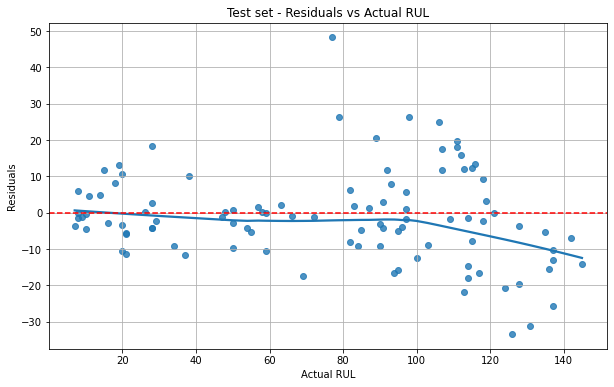

In [44]:
test_model(ngb, X_test, test_units['Unit'], rul, plot_figures=True)

In [ ]:
#test_model(ngb, X_test[SELECTED_FEATURES], test_units['Unit'], rul, plot_figures=True)

In [45]:
model = ngb
engines = test_units['Unit']
test_rul = rul
X_test_last = X_test.groupby(engines, as_index=False).last()

In [46]:
pred_rul = model.predict(X_test_last)
pred_rul

array([127.88068002, 124.42768182,  51.47899094,  73.94510701,
        86.90218991, 100.90415383,  93.94984116,  89.94289475,
       129.04205799,  92.01389838, 102.82049995, 103.33863693,
        79.14966918, 118.6701281 ,  84.83361918,  74.76394113,
        40.38047043,  30.74732719,  88.17998421,  13.12385607,
        58.56422354, 130.62204187, 124.94454088,  16.49484768,
       130.7916297 , 122.14019807,  64.9778154 ,  95.36782102,
        86.94645414, 107.31316191,   6.54449043,  48.19091092,
       130.87483886,   3.36927608,  15.53679222,  32.08077218,
        15.27614942,  50.72621817, 134.99586239,  46.31126734,
        26.06978038,   9.59450908,  48.3946597 , 107.17170674,
        99.3422186 ,  45.82061711, 129.62956623, 103.65646751,
         9.75855241, 105.48922352,  96.14696204,  26.81762058,
        26.25402785,  97.98038705, 111.40291759,  26.813789  ,
        94.19599246,  25.47376519, 112.54737965,  87.5907638 ,
        15.31548388,  49.87258002,  70.85101319,  23.92

In [47]:
#pred_rul = model.predict(X_test_last.values)
pred_rul = model.predict(X_test_last.values[0].reshape(1,-1))
print(pred_rul)

[127.88068002]


In [48]:
rul_metrics_score(model, X_test_last.values, test_rul, metrics='all')

{'rmse': 12.6673893976529,
 'mae': 9.352091382178823,
 'mape': 0.1689747880303244}

In [89]:
import pickle
pickle.dump(ngb, open('model.pkl','wb'))